### Things that worked for me:
* One hot encoding categorical columns
* Remove skewness from ['Demand', 'High_Cap_Price'] columns and target column too.
* Normalize numerical columns ['Demand', 'High_Cap_Price']
* Ensembling various regression models
* Datetime format taken into use: broken down to 3 columns namely ['dates','month','year'] but used only 'year' column for training.

### Things that didn't work:
* Pseudo labeling with ensembling
* LabelEncoding

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackerearth-ml-slashing-prices-for-biggest-sale/sample_submission.csv
/kaggle/input/hackerearth-ml-slashing-prices-for-biggest-sale/Test.csv
/kaggle/input/hackerearth-ml-slashing-prices-for-biggest-sale/Train.csv


![](https://image.freepik.com/free-vector/summer-sale-background-with-beach_23-2147820808.jpg)

## About the Dataset:
[Hacker_Earth_Challenge](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-predict-the-lowest-price/)

The dataset consists of various parameters such as a unique item ID, category of the market to which a product belongs, category and quality of the product, its demand rate, and its original market price.

We are supposed to build a predictive model that determines the lowest price at which a good can be sold on the day of sale.

In [2]:
train_df = pd.read_csv('../input/hackerearth-ml-slashing-prices-for-biggest-sale/Train.csv')
test_df = pd.read_csv('../input/hackerearth-ml-slashing-prices-for-biggest-sale/Test.csv')
sample = pd.read_csv('../input/hackerearth-ml-slashing-prices-for-biggest-sale/sample_submission.csv')

In [3]:
train_df.head()

,Item_Id,Date,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price
0,IT_1,2007-07-05,0,0,0,0,0.5,2785,4240
1,IT_2,2007-07-05,0,1,0,0,0.7,3574,4756
2,IT_3,2007-07-05,0,103,0,1,1.6,5978,9669
3,IT_4,2007-07-05,0,103,0,0,0.0,5681,8313
4,IT_5,2007-07-05,0,103,0,2,0.0,4924,7257


### Checking target skewness

mu 3500.2735252092266, sigma 2187.9351419173813


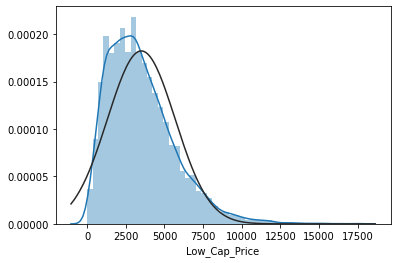

In [4]:
from scipy.stats import norm
sns.distplot(train_df["Low_Cap_Price"],fit=norm)
mu,sigma= norm.fit(train_df['Low_Cap_Price'])
print("mu {}, sigma {}".format(mu,sigma))

mu 7.94147534144671, sigma 0.7232791338493658


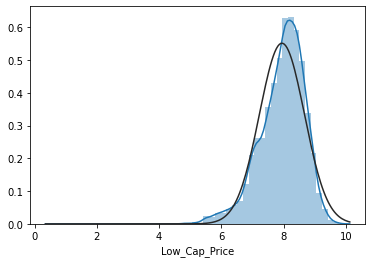

In [5]:
# Removing skewness
########## REMOVING SKEWEENESS ###########
train_df['Low_Cap_Price']=np.log1p(train_df['Low_Cap_Price'])
sns.distplot(train_df['Low_Cap_Price'],fit=norm)
mu,sigma= norm.fit(train_df['Low_Cap_Price'])
print("mu {}, sigma {}".format(mu,sigma))

In [6]:
test_df['Low_Cap_Price'] = -1

### Merging test with train to do one hot encoding at once

In [7]:
df = pd.merge(train_df, test_df, how='outer')
df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,Item_Id,Date,State_of_Country,Market_Category,Product_Category,Grade,Demand,Low_Cap_Price,High_Cap_Price
0,IT_1,2007-07-05,0,0,0,0,0.5,7.932362,4240
1,IT_2,2007-07-05,0,1,0,0,0.7,8.181720,4756
2,IT_3,2007-07-05,0,103,0,1,1.6,8.696009,9669
3,IT_4,2007-07-05,0,103,0,0,0.0,8.645059,8313
4,IT_5,2007-07-05,0,103,0,2,0.0,8.502080,7257


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

### Extracting year information
This step gave me a significant jump in LB

In [9]:
# df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
# df['dates'] = df['Date'].dt.day

In [10]:
df['State_of_Country'].corr(df['Low_Cap_Price'])

-0.06244835688940031

### Removing skewness form other numerical columns

In [11]:
numeric_col = ['Demand','High_Cap_Price']
skew=df[numeric_col].skew()
skew

Demand             45.131583
High_Cap_Price    124.737404
dtype: float64

In [12]:
from scipy.special import boxcox1p
lam=0.15
for i in skew.index:
    df[i]=np.log1p(df[i])

### One_Hot Encoding

In [13]:
# One Hot
df = pd.get_dummies(df, columns=['State_of_Country','Market_Category','Product_Category','Grade','year'])
# test_df = pd.get_dummies(test_df, columns=['State_of_Country','Market_Category','Product_Category','Grade'])

In [14]:


#Normalize Demand and High_Cap_Price
df['Demand'] = (df['Demand'] - np.mean(df['Demand'])) / (np.max(df['Demand']) - np.min(df['Demand']))
# test_df['Demand'] = (test_df['Demand'] - np.mean(test_df['Demand'])) / (np.max(test_df['Demand']) - np.min(test_df['Demand']))

df['High_Cap_Price'] = (df['High_Cap_Price'] - np.mean(df['High_Cap_Price'])) / (np.max(df['High_Cap_Price']) - np.min(df['High_Cap_Price']))
# test_df['High_Cap_Price'] = (test_df['High_Cap_Price'] - np.mean(test_df['High_Cap_Price'])) / (np.max(test_df['High_Cap_Price']) - np.min(test_df['High_Cap_Price']))

## Preparation for Ensembling various regression models

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet,BayesianRidge
from sklearn.preprocessing import RobustScaler

In [16]:
features = [c for c in df.columns if c not in ['Item_Id','Date','Low_Cap_Price']]
features

['Demand',
 'High_Cap_Price',
 'State_of_Country_0',
 'State_of_Country_1',
 'State_of_Country_2',
 'State_of_Country_3',
 'State_of_Country_4',
 'State_of_Country_5',
 'State_of_Country_6',
 'State_of_Country_7',
 'State_of_Country_8',
 'State_of_Country_9',
 'State_of_Country_10',
 'State_of_Country_11',
 'State_of_Country_12',
 'State_of_Country_13',
 'State_of_Country_14',
 'State_of_Country_15',
 'State_of_Country_17',
 'State_of_Country_18',
 'State_of_Country_19',
 'State_of_Country_20',
 'State_of_Country_21',
 'State_of_Country_22',
 'State_of_Country_23',
 'Market_Category_0',
 'Market_Category_1',
 'Market_Category_2',
 'Market_Category_3',
 'Market_Category_4',
 'Market_Category_6',
 'Market_Category_7',
 'Market_Category_8',
 'Market_Category_9',
 'Market_Category_10',
 'Market_Category_11',
 'Market_Category_12',
 'Market_Category_13',
 'Market_Category_14',
 'Market_Category_15',
 'Market_Category_16',
 'Market_Category_17',
 'Market_Category_18',
 'Market_Category_19',


In [17]:
train_df = df[df['Low_Cap_Price']!=-1]
test_df = df[df['Low_Cap_Price']==-1]

In [18]:
print(len(train_df.columns))
print(len(test_df.columns))

429
429


In [19]:
X = train_df[features]
y = train_df['Low_Cap_Price']

x_test = test_df[features]

In [20]:
xgb = XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1, 
                    importance_type='gain', interaction_constraints=None,
                     min_child_weight=1, missing=None, monotone_constraints=None,
                     n_estimators=700, n_jobs=-1, nthread=-1, num_parallel_tree=1
                    )
xgb.fit(X, y)
pred_1 = xgb.predict(x_test)
pred_1[pred_1 < 0] = 1

In [21]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.03, n_estimators=2200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgb.fit(X,y)
pred_2 = model_lgb.predict(x_test)


In [22]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5,)
GBoost.fit(X, y)
pred_4 = GBoost.predict(x_test)


In [23]:
#XGBOOST
model=XGBRegressor(n_estimators=2200,learning_rate=0.05)
model.fit(X,y)

pred_6 = model.predict(x_test)


In [24]:
# pred_1 = 0.7*(pred_1 + pred_2)/2.0 + 0.3*(pred_5 + pred_4)/2.0

In [25]:
pred_1 = np.expm1(pred_1)
pred_2 = np.expm1(pred_2)
# pred_3 = np.expm1(pred_3)
pred_4 = np.expm1(pred_4)
# pred_5 = np.expm1(pred_5)
pred_6 = np.expm1(pred_6)
# pred_7 = np.expm1(pred_7)

In [26]:
pred_1 = (pred_1 + pred_6 + pred_2 + pred_4)/4.0

In [27]:
sub = pd.DataFrame({'Item_Id':test_df.Item_Id.values,
                   'Low_Cap_Price':pred_1})
sub.to_csv('submission_ensemble.csv', index=False)

# If you like my kernel, do Upvote :)